In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# python packages
import warnings
warnings.filterwarnings('ignore')
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout
from keras.models import Sequential, Model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator


In [3]:
IMAGE_SIZE=[150,150]

In [4]:
datagen = ImageDataGenerator(rescale = 1./255, #shear_range= 0.2, zoom_range= 0.2, horizontal_flip= True,
                              validation_split= 0.2)
training_set = datagen.flow_from_directory('C:\\Users\\44749\\Desktop\\Main Folders\\Final Year Project\\Dataset folders\\Original Dataset\\Training', target_size=IMAGE_SIZE, batch_size=64,    
                                            class_mode='categorical',subset='training',  shuffle=True)
valid_set = datagen.flow_from_directory('C:\\Users\\44749\\Desktop\\Main Folders\\Final Year Project\\Dataset folders\\Original Dataset\\Training', target_size=IMAGE_SIZE, batch_size=64, 
                                            class_mode='categorical', subset='validation',shuffle=True)
test_set = datagen.flow_from_directory('C:\\Users\\44749\\Desktop\\Main Folders\\Final Year Project\\Dataset folders\\Original Dataset\\Testing', target_size=IMAGE_SIZE, batch_size=64, 
                                            class_mode='categorical',shuffle=True)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [45]:
# deep learning packages and modules
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Flatten, Dense, Conv2D, AveragePooling2D, BatchNormalization, SpatialDropout2D
from keras.utils import to_categorical

In [6]:
nb_classes = 4

In [7]:
""" importing vgg model and its imagenet weights
and freezing its layers, and defining output layer
"""
vgg = VGG16(input_shape= IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)
x = vgg.output
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
prediction = Dense(nb_classes, activation='softmax')(x)

for layers in vgg.layers:
    layers.trainable = False

model_name = 'vgg16.h5'
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.003, patience=15, verbose=1, mode='auto',
                              restore_best_weights=True)
checkpoint_fixed_name = ModelCheckpoint(model_name,
                                            monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='auto', period=5)
callbacks = [checkpoint_fixed_name, early_stop]

model = Model( inputs = vgg.input, outputs = prediction)
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics= ['accuracy'])

In [8]:
# train model
history = model.fit_generator(training_set,epochs=50,steps_per_epoch=int(len(training_set)/8),
                    validation_steps=int(len(test_set)/4),validation_data=valid_set,
                   callbacks=callbacks)

Epoch 1/50
4/4 [==============================] - 12s 636ms/step - loss: 3.7728 - accuracy: 0.3146 - val_loss: 2.7343 - val_accuracy: 0.1094
Epoch 2/50
4/4 [==============================] - 1s 165ms/step - loss: 2.2622 - accuracy: 0.2672 - val_loss: 1.6754 - val_accuracy: 0.3906
Epoch 3/50
4/4 [==============================] - 1s 166ms/step - loss: 1.5806 - accuracy: 0.4281 - val_loss: 1.1911 - val_accuracy: 0.4688
Epoch 4/50
4/4 [==============================] - 1s 166ms/step - loss: 1.1353 - accuracy: 0.5490 - val_loss: 0.9333 - val_accuracy: 0.6406
Epoch 5/50
4/4 [==============================] - 1s 164ms/step - loss: 1.0281 - accuracy: 0.5672 - val_loss: 0.9894 - val_accuracy: 0.5938

Epoch 00005: val_loss improved from inf to 0.98941, saving model to vgg16.h5
Epoch 6/50
4/4 [==============================] - 1s 165ms/step - loss: 0.8277 - accuracy: 0.6875 - val_loss: 1.2894 - val_accuracy: 0.4062
Epoch 7/50
4/4 [==============================] - 1s 163ms/step - loss: 0.9557 - 

In [9]:
model.evaluate_generator(test_set, steps=int(len(test_set)/2))

[1.539307713508606, 0.4583333432674408]

In [10]:
# save trained model
#model.save('vgg16.h5')

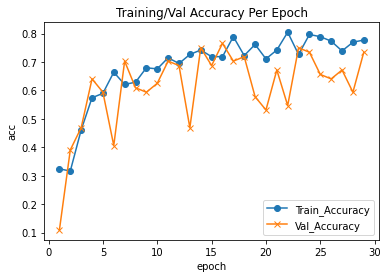

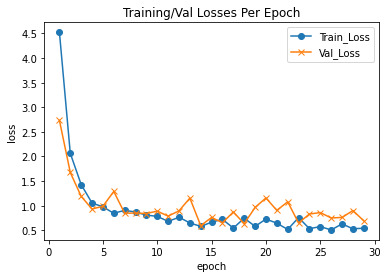

In [11]:
# plotting loss graphs w.r.t each epoch
f, ax = plt.subplots()
ax.plot([None] + history.history['accuracy'], 'o-')
ax.plot([None] + history.history["val_accuracy"], 'x-')

ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
ax.set_title('Training/Val Accuracy Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
plt.show()

f, ax = plt.subplots()
ax.plot([None] + history.history["loss"], 'o-')
ax.plot([None] + history.history["val_loss"], 'x-')

ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
ax.set_title('Training/Val Losses Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

In [12]:
""" importing resnet 50 model and its imagenet weights
and freezing its layers, and defining output layer
"""
resnet_ = ResNet50(input_shape= IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)
x = resnet_.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
prediction = Dense(nb_classes, activation='softmax')(x)

for layers in resnet_.layers:
    layers.trainable = False

model_name = 'resnet.h5'
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.003, patience=15, verbose=1, mode='auto',
                              restore_best_weights=True)
checkpoint_fixed_name = ModelCheckpoint(model_name,
                                            monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='auto', period=10)
callbacks = [checkpoint_fixed_name, early_stop]

resnet = Model( inputs = resnet_.input, outputs = prediction)
resnet.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics= ['accuracy'])

In [13]:
history = resnet.fit_generator(training_set,epochs=50,steps_per_epoch=int(len(training_set)/8),
                    validation_steps=int(len(test_set)/4),validation_data=valid_set,
                    callbacks=callbacks)

Epoch 1/50
4/4 [==============================] - 7s 537ms/step - loss: 3.7481 - accuracy: 0.1583 - val_loss: 1.7480 - val_accuracy: 0.4375
Epoch 2/50
4/4 [==============================] - 1s 160ms/step - loss: 3.1551 - accuracy: 0.2740 - val_loss: 1.4367 - val_accuracy: 0.3594
Epoch 3/50
4/4 [==============================] - 1s 157ms/step - loss: 1.7691 - accuracy: 0.3333 - val_loss: 1.8447 - val_accuracy: 0.2344
Epoch 4/50
4/4 [==============================] - 1s 164ms/step - loss: 1.7048 - accuracy: 0.3286 - val_loss: 1.3515 - val_accuracy: 0.3438
Epoch 5/50
4/4 [==============================] - 1s 175ms/step - loss: 1.4903 - accuracy: 0.2875 - val_loss: 1.2632 - val_accuracy: 0.2812
Epoch 6/50
4/4 [==============================] - 1s 165ms/step - loss: 1.3415 - accuracy: 0.3339 - val_loss: 1.9104 - val_accuracy: 0.2656
Epoch 7/50
4/4 [==============================] - 1s 156ms/step - loss: 1.7833 - accuracy: 0.3531 - val_loss: 1.2141 - val_accuracy: 0.3438
Epoch 8/50
4/4 [====

In [14]:
resnet.evaluate_generator(test_set, steps=int(len(test_set)/32))

[]

In [15]:
# save trained model
# resnet.save('resnet.h5')

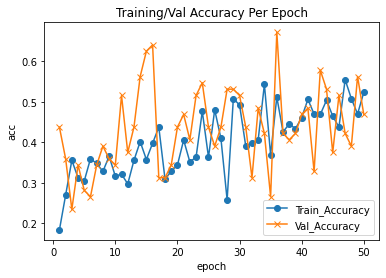

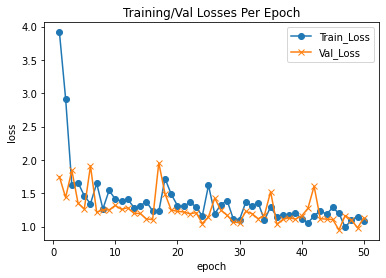

In [16]:
# plotting loss graphs w.r.t each epoch
f, ax = plt.subplots()
ax.plot([None] + history.history["accuracy"], 'o-')
ax.plot([None] + history.history["val_accuracy"], 'x-')

ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
ax.set_title('Training/Val Accuracy Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
plt.show()

f, ax = plt.subplots()
ax.plot([None] + history.history["loss"], 'o-')
ax.plot([None] + history.history["val_loss"], 'x-')

ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
ax.set_title('Training/Val Losses Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

In [17]:
""" importing xception model and its imagenet weights
and freezing its layers, and defining output layer
"""
xception_ = Xception(input_shape= IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)
x = xception_.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
prediction = Dense(nb_classes, activation='softmax')(x)

for layers in xception_.layers:
    layers.trainable = False

model_name = 'xception.h5'
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.003, patience=15, verbose=1, mode='auto',
                              restore_best_weights=True)
checkpoint_fixed_name = ModelCheckpoint(model_name,
                                            monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='auto', period=10)
callbacks = [checkpoint_fixed_name, early_stop]

xception = Model( inputs = xception_.input, outputs = prediction)
xception.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics= ['accuracy'])

In [18]:
history = xception.fit_generator(training_set,epochs=50,steps_per_epoch=int(len(training_set)/8),
                    validation_steps=int(len(test_set)/4),validation_data=valid_set,
                      callbacks=callbacks)

Epoch 1/50
4/4 [==============================] - 6s 485ms/step - loss: 9.8070 - accuracy: 0.3245 - val_loss: 11.7830 - val_accuracy: 0.4062
Epoch 2/50
4/4 [==============================] - 1s 167ms/step - loss: 8.9014 - accuracy: 0.3922 - val_loss: 2.5620 - val_accuracy: 0.5312
Epoch 3/50
4/4 [==============================] - 1s 202ms/step - loss: 3.9432 - accuracy: 0.4307 - val_loss: 2.9110 - val_accuracy: 0.5781
Epoch 4/50
4/4 [==============================] - 1s 168ms/step - loss: 2.8732 - accuracy: 0.4562 - val_loss: 1.2667 - val_accuracy: 0.5938
Epoch 5/50
4/4 [==============================] - 1s 174ms/step - loss: 2.0293 - accuracy: 0.5411 - val_loss: 0.9375 - val_accuracy: 0.6875
Epoch 6/50
4/4 [==============================] - 1s 169ms/step - loss: 1.2591 - accuracy: 0.6349 - val_loss: 1.0165 - val_accuracy: 0.6406
Epoch 7/50
4/4 [==============================] - 1s 188ms/step - loss: 1.4254 - accuracy: 0.6401 - val_loss: 0.6934 - val_accuracy: 0.7812
Epoch 8/50
4/4 [===

In [19]:
xception.evaluate_generator(test_set, steps=int(len(test_set)/32))

[]

In [20]:
# saving model
# xception.save('xception.h5')

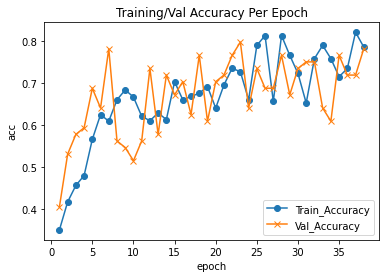

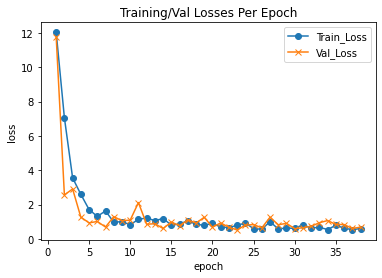

In [21]:
# plotting loss graphs w.r.t each epoch
f, ax = plt.subplots()
ax.plot([None] + history.history["accuracy"], 'o-')
ax.plot([None] + history.history["val_accuracy"], 'x-')

ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
ax.set_title('Training/Val Accuracy Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
plt.show()

f, ax = plt.subplots()
ax.plot([None] + history.history["loss"], 'o-')
ax.plot([None] + history.history["val_loss"], 'x-')

ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
ax.set_title('Training/Val Losses Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

In [22]:
""" importing vgg-19 model and its imagenet weights
and freezing its layers, and defining output layer
"""
vgg19 = VGG19(input_shape= IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)
x = vgg19.output
x = Flatten()(x)
x = Dense(128, activation='elu')(x)
x = Dense(64, activation='elu')(x)
x = Dropout(0.3)(x)
prediction = Dense(nb_classes, activation='softmax')(x)

for layers in vgg19.layers:
    layers.trainable = False

model_name = 'vgg19.h5'
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.003, patience=15, verbose=1, mode='auto',
                              restore_best_weights=True)
checkpoint_fixed_name = ModelCheckpoint(model_name,
                                            monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='auto', period=10)
callbacks = [checkpoint_fixed_name, early_stop]

vgg = Model( inputs = vgg19.input, outputs = prediction)
vgg.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics= ['accuracy'])

In [23]:
history = vgg.fit_generator(training_set,epochs=50,steps_per_epoch=int(len(training_set)/8),
                    validation_steps=int(len(test_set)/4),validation_data=valid_set,
                 callbacks=callbacks)

Epoch 1/50
4/4 [==============================] - 2s 318ms/step - loss: 5.1049 - accuracy: 0.3271 - val_loss: 2.8588 - val_accuracy: 0.2188
Epoch 2/50
4/4 [==============================] - 1s 191ms/step - loss: 3.3348 - accuracy: 0.2981 - val_loss: 1.7846 - val_accuracy: 0.3281
Epoch 3/50
4/4 [==============================] - 1s 195ms/step - loss: 1.9416 - accuracy: 0.3448 - val_loss: 1.2947 - val_accuracy: 0.5625
Epoch 4/50
4/4 [==============================] - 1s 203ms/step - loss: 1.3288 - accuracy: 0.4557 - val_loss: 1.0833 - val_accuracy: 0.3906
Epoch 5/50
4/4 [==============================] - 1s 198ms/step - loss: 1.2025 - accuracy: 0.4995 - val_loss: 1.3258 - val_accuracy: 0.5781
Epoch 6/50
4/4 [==============================] - 1s 197ms/step - loss: 1.0821 - accuracy: 0.5276 - val_loss: 0.9927 - val_accuracy: 0.4531
Epoch 7/50
4/4 [==============================] - 1s 197ms/step - loss: 1.0805 - accuracy: 0.5234 - val_loss: 1.3030 - val_accuracy: 0.4375
Epoch 8/50
4/4 [====

In [24]:
vgg.evaluate_generator(test_set, steps=int(len(test_set)/32))

[]

In [25]:
# save model
# vgg.save('vgg19.h5')

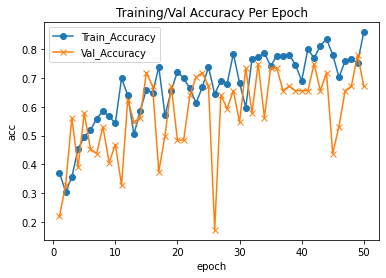

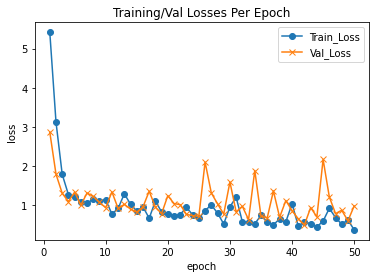

In [26]:
# plotting loss graphs w.r.t each epoch
f, ax = plt.subplots()
ax.plot([None] + history.history["accuracy"], 'o-')
ax.plot([None] + history.history["val_accuracy"], 'x-')

ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
ax.set_title('Training/Val Accuracy Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
plt.show()

f, ax = plt.subplots()
ax.plot([None] + history.history["loss"], 'o-')
ax.plot([None] + history.history["val_loss"], 'x-')

ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
ax.set_title('Training/Val Losses Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

### Custom Model

In [27]:
model= Sequential()

model.add(Conv2D(64, kernel_size= (3,3), activation='tanh', input_shape=IMAGE_SIZE + [3],padding='same',
                strides=(1,1)))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding= 'valid'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))
model.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', input_shape= IMAGE_SIZE + [3], padding='same',
                strides= (1,1)))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())

model.add(SpatialDropout2D(0.3))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(nb_classes, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

model_name = 'custom.h5'
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.003, patience=15, verbose=1, mode='auto',
                              restore_best_weights=True)
checkpoint_fixed_name = ModelCheckpoint(model_name,
                                            monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='auto', period=10)
callbacks = [checkpoint_fixed_name, early_stop]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
average_pooling2d (AveragePo (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 37, 37, 64)        2

In [28]:
history = model.fit_generator(training_set,epochs=50,steps_per_epoch=int(len(training_set)/8),
                    validation_steps=int(len(test_set)/4),validation_data=valid_set,
                   callbacks=callbacks)

Epoch 1/50
4/4 [==============================] - 3s 206ms/step - loss: 20.5481 - accuracy: 0.3292 - val_loss: 1.5001 - val_accuracy: 0.1562
Epoch 2/50
4/4 [==============================] - 0s 113ms/step - loss: 8.6047 - accuracy: 0.4474 - val_loss: 1.6154 - val_accuracy: 0.2344
Epoch 3/50
4/4 [==============================] - 0s 111ms/step - loss: 2.0278 - accuracy: 0.5089 - val_loss: 1.9716 - val_accuracy: 0.1250
Epoch 4/50
4/4 [==============================] - 0s 109ms/step - loss: 2.6028 - accuracy: 0.3250 - val_loss: 1.4845 - val_accuracy: 0.1250
Epoch 5/50
4/4 [==============================] - 0s 116ms/step - loss: 1.5416 - accuracy: 0.4458 - val_loss: 1.3361 - val_accuracy: 0.2031
Epoch 6/50
4/4 [==============================] - 0s 115ms/step - loss: 1.8286 - accuracy: 0.3880 - val_loss: 1.3163 - val_accuracy: 0.2500
Epoch 7/50
4/4 [==============================] - 1s 163ms/step - loss: 1.8370 - accuracy: 0.3547 - val_loss: 1.2666 - val_accuracy: 0.2500
Epoch 8/50
4/4 [===

In [29]:
model.evaluate_generator(test_set, steps=int(len(test_set)/32))

[]

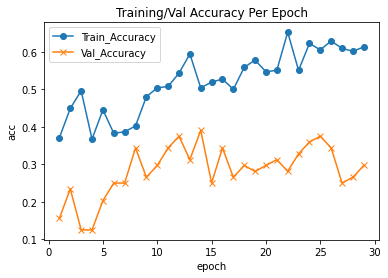

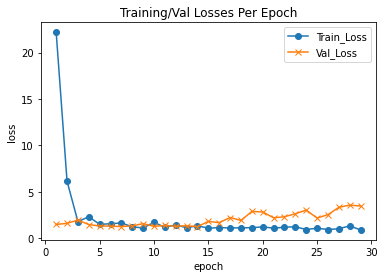

In [30]:
# plotting loss graphs w.r.t each epoch
f, ax = plt.subplots()
ax.plot([None] + history.history["accuracy"], 'o-')
ax.plot([None] + history.history["val_accuracy"], 'x-')

ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
ax.set_title('Training/Val Accuracy Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
plt.show()

f, ax = plt.subplots()
ax.plot([None] + history.history["loss"], 'o-')
ax.plot([None] + history.history["val_loss"], 'x-')

ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
ax.set_title('Training/Val Losses Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

### MLP

In [31]:
def preprocess(img):
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (int(128),int(128)))
    img = img/255
    return img

In [32]:
# loading images data and labeling it
train_img = []
train_label = []
for path in glob(r'C:\Users\44749\Desktop\Main Folders\Final Year Project\Dataset folders\Original Dataset\Training\*'):
    for img in glob('%s/*'%path):
        image = preprocess(img)
        train_img.append(image)
        train_label.append(path.split('\\')[-1])
train_img = np.array(train_img)
train_label = np.array(train_label)

In [33]:
# loading test images data and labeling it
test_img = []
test_label = []
for path in glob('C:\\Users\\44749\\Desktop\\Main Folders\\Final Year Project\\Dataset folders\\Original Dataset\\Testing\*'):
    for img in glob('%s/*'%path):
        image = preprocess(img)
        test_img.append(image)
        test_label.append(path.split('\\')[-1])
test_img = np.array(test_img)
test_label = np.array(test_label)

In [34]:
le = LabelEncoder()
le.fit(train_label)

train_label = to_categorical(le.transform(train_label))
test_label = to_categorical(le.transform(test_label))

In [35]:
train_img = train_img.reshape(train_img.shape[0],-1)
test_img = test_img.reshape(test_img.shape[0],-1)

In [36]:
mlp= Sequential()
mlp.add(Dense(512, activation='relu', input_shape=(train_img.shape[1],)))
mlp.add(Dropout(0.3))
mlp.add(Dense(256, activation='sigmoid'))
mlp.add(Dropout(0.3))
mlp.add(Dense(128, activation='sigmoid'))
mlp.add(Dropout(0.3))
mlp.add(Dense(nb_classes, activation = 'softmax'))

mlp.compile(loss = 'categorical_crossentropy', optimizer= 'rmsprop', metrics = ['accuracy'])

model_name = 'mlp.h5'
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.003, patience=15, verbose=1, mode='auto',
                              restore_best_weights=True)
checkpoint_fixed_name = ModelCheckpoint(model_name,
                                            monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='auto', period=10)
callbacks = [checkpoint_fixed_name, early_stop]

In [37]:
history = mlp.fit(train_img,train_label,epochs=50,batch_size=128,validation_split=0.2,
       callbacks=callbacks)

Epoch 1/50
18/18 [==============================] - 1s 30ms/step - loss: 1.4211 - accuracy: 0.3400 - val_loss: 1.4592 - val_accuracy: 0.5174
Epoch 2/50
18/18 [==============================] - 0s 19ms/step - loss: 1.2219 - accuracy: 0.4069 - val_loss: 1.7637 - val_accuracy: 0.4617
Epoch 3/50
18/18 [==============================] - 0s 19ms/step - loss: 1.1490 - accuracy: 0.4370 - val_loss: 2.1572 - val_accuracy: 0.1254
Epoch 4/50
18/18 [==============================] - 0s 19ms/step - loss: 1.1080 - accuracy: 0.4620 - val_loss: 2.1615 - val_accuracy: 0.3902
Epoch 5/50
18/18 [==============================] - 0s 19ms/step - loss: 1.0230 - accuracy: 0.5146 - val_loss: 1.5200 - val_accuracy: 0.6289
Epoch 6/50
18/18 [==============================] - 0s 19ms/step - loss: 0.9360 - accuracy: 0.5436 - val_loss: 2.5033 - val_accuracy: 0.2404
Epoch 7/50
18/18 [==============================] - ETA: 0s - loss: 0.9581 - accuracy: 0.55 - 0s 19ms/step - loss: 0.9548 - accuracy: 0.5582 - val_loss: 1

In [38]:
mlp.evaluate(test_img, test_label, batch_size=32)

13/13 [==============================] - 0s 4ms/step - loss: 1.7547 - accuracy: 0.4086


[1.7547358274459839, 0.408629447221756]

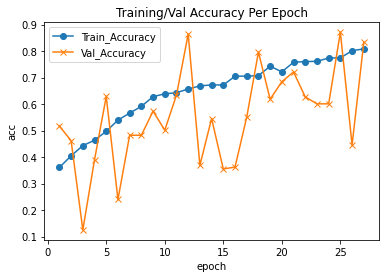

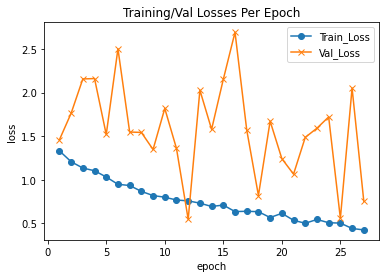

In [39]:
# plotting loss graphs w.r.t each epoch
f, ax = plt.subplots()
ax.plot([None] + history.history["accuracy"], 'o-')
ax.plot([None] + history.history["val_accuracy"], 'x-')

ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
ax.set_title('Training/Val Accuracy Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
plt.show()

f, ax = plt.subplots()
ax.plot([None] + history.history["loss"], 'o-')
ax.plot([None] + history.history["val_loss"], 'x-')

ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
ax.set_title('Training/Val Losses Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

# Prediction

In [40]:
from keras.models import load_model

In [44]:
vgg = load_model('custom.h5')

ValueError: No model found in config file.

In [42]:
training_set.class_indices

{'BEN': 0, 'MAL': 1, 'NO': 2, 'PIT': 3}

In [113]:
ben = "Training/BEN/0.jpg"
mal = "Training/MAL/402.jpg"
no = "Training/NO/59.jpg"
pit = "Training/PIT/504.jpg"

images = [ben,mal,no,pit]

In [114]:
images = [cv2.imread(i) for i in images]
images = np.array([cv2.resize(i, (int(150),int(150))) for i in images])

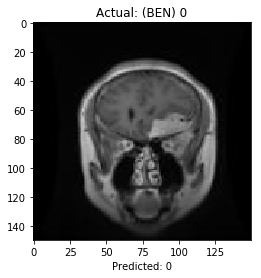

In [115]:
plt.imshow(images[0])
plt.title('Actual: (BEN) 0')
result = np.argmax(vgg.predict(images[[0]]/255))
plt.xlabel('Predicted: %s'%result)
plt.show()

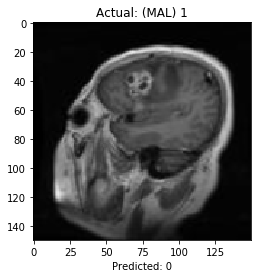

In [116]:
plt.imshow(images[1])
plt.title('Actual: (MAL) 1')
result = np.argmax(vgg.predict(images[[1]]/255))
plt.xlabel('Predicted: %s'%result)
plt.show()

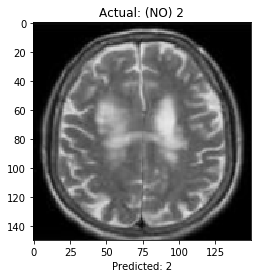

In [117]:
plt.imshow(images[2])
plt.title('Actual: (NO) 2')
result = np.argmax(vgg.predict(images[[2]]/255))
plt.xlabel('Predicted: %s'%result)
plt.show()

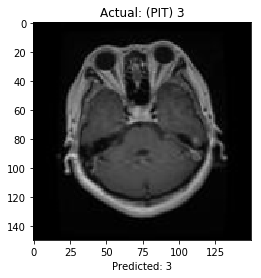

In [118]:
plt.imshow(images[3])
plt.title('Actual: (PIT) 3')
result = np.argmax(vgg.predict(images[[3]]/255))
plt.xlabel('Predicted: %s'%result)
plt.show()

In [22]:
model.history.history

{}